# We used the COCO Dataset

In [5]:
import os
import sys
sys.path.append('cocoapi/PythonAPI')
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = 'cocoapi'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
print(instances_annFile)
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

cocoapi\annotations/instances_val2014.json
loading annotations into memory...
Done (t=5.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


# Plotting a Sample Image

In [ ]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [ ]:
# Preview the word2idx dictionary.
print (dict(list(data_loader.dataset.vocab.word2idx.items())[:10]))

# print the total number of keys in the word2idx dictionary.
print('Total number of tokens in vocabulary:', len(data_loader.dataset.vocab))

In [ ]:
unk_word = data_loader.dataset.vocab.unk_word
print('Special unknown word:', unk_word)

print('All unknown words are mapped to this integer:', data_loader.dataset.vocab(unk_word))
print ("For example:")
print("'jfkafejw' is mapped to", data_loader.dataset.vocab('jfkafejw'))

In [1]:
import nltk
import pickle
import os.path
from pycocotools.coco import COCO
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        
          #vocab_threshold: Minimum word count threshold.
          #vocab_file: File containing the vocabulary.
          #start_word: Special word denoting sentence start.
          #end_word: Special word denoting sentence end.
          #unk_word: Special word denoting unknown words.
          #annotations_file: Path for train annotation file.
          #vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           #If True, load vocab from from existing vocab_file, if it exists
        
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        # Load the vocabulary from file OR build the vocabulary from scratch.
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f) # save new word
        
    def build_vocab(self):
        #Populate the dictionaries for converting tokens to integers (and vice-versa).
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        #Initialize the dictionaries for converting tokens to integers (and vice-versa).
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        #Add a token to the vocabulary.
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        #Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold.
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# Exploring the Data Loader

In [2]:
import nltk
import os
import torch
import torch.utils.data as data
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import random
import json

def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               cocoapi_loc=''):
    
    
      #transform: Image transform.
      #mode: One of 'train' or 'test'.
      #batch_size: Batch size (if in testing mode, must have batch_size=1).
      #vocab_threshold: Minimum word count threshold.
      #vocab_file: File containing the vocabulary. 
      #start_word: Special word denoting sentence start.
      #end_word: Special word denoting sentence end.
      #unk_word: Special word denoting unknown words.
      #vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       #If True, load vocab from from existing vocab_file, if it exists.
      #num_workers: Number of subprocesses to use for data loading 
      #cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
        annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
#         The get_train_indices method in the CoCoDataset class first samples a caption length, and then samples 
#         batch_size indices corresponding to training data points with captions of that length. These indices are 
#         stored below in indices.

#         These indices are supplied to the data loader, which then is used to retrieve the corresponding data points. 
#         The pre-processed images and captions in the batch are stored in images and captions.
        
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        # We have to specify batch_sampler as sampler, otherwise the batch will be divided into single indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image
    # The get_train_indices method in the CoCoDataset class first samples a caption length, 
    # and then samples batch_size indices corresponding to training data points with captions of that length. 
    # These indices are stored below in indices.

    #These indices are supplied to the data loader, which then is used to retrieve the corresponding data points. 
    # The pre-processed images and captions in the batch are stored in images and captions.
    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False) # We want to freeze part of your model and train the rest, 
                                        # we will set requires_grad of the parameters you want to freeze to False.
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1) # here we are reshaping the tensor
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(num_embeddings = vocab_size,
                                  embedding_dim = embed_size)
        
        self.lstm = nn.LSTM(input_size = embed_size,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            batch_first = True) # Our input data is of shape (batch_size, seq_len, features) 
                                                # so then we need batch_first=True and your LSTM will give output of 
                                                # shape (batch_size, seq_len, hidden_size).
        
        self.linear = nn.Linear(in_features = hidden_size,
                                out_features = vocab_size)
        self.max_seg_length = max_seq_length
        
       # unsqueeze(dim = 1) If you add at the 1 position, it will be (3,1), which means 3 rows and 1 column. 
        
    
    def forward(self, features, captions):
        captions = captions[:, :-1]
        embedding = self.embed(captions)
        embedding = torch.cat((features.unsqueeze(dim = 1), embedding), dim = 1) # concatenate 2 layers
        lstm_out, hidden = self.lstm(embedding)
        outputs = self.linear(lstm_out)
        return outputs
    
    def sample(self, features, states=None):
        #Generate captions for given image features using greedy search.
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # removed 1 dim           # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                        # inputs: (batch_size, 1, embed_size)
                                                                    #torch.stack Concatenates a sequence of tensors along a new dimension.
                                                                    # All tensors need to be of the same size.
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torch.nn as nn
from torchvision import transforms
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
import math



batch_size = 128          # batch size
vocab_threshold = 5        # minimum word count threshold
vocab_from_file = False    # if True, load existing vocab file
embed_size = 300          # dimensionality of image and word embeddings
hidden_size = 512         # number of features in hidden state of the RNN decoder
num_epochs = 3             # number of training epochs
save_every = 1             # determines frequency of saving model weights
print_every = 100          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# The data augmentation step transforms.RandomHorizontalFlip() improves the accuracy of the image classification task
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)


vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)


criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()


params = list(decoder.parameters()) + list(encoder.embed.parameters())


optimizer = torch.optim.Adam(params = params, lr = 0.001)


total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

loading annotations into memory...
Done (t=0.50s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Obtaining caption lengths...


100%|███████████████████████████████████████████████████████████████████████| 414113/414113 [00:31<00:00, 13052.37it/s]


In [8]:
import torch.utils.data as data
import numpy as np
import os
import requests
import time

f = open(log_file, 'w')

old_time = time.time()


for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        
        images, captions = next(iter(data_loader))

        
        images = images.to(device)
        captions = captions.to(device)
        
        
        decoder.zero_grad()
        encoder.zero_grad()
        
        
        features = encoder(images)
        outputs = decoder(features, captions)
        
        
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        
        loss.backward()
        
        
        optimizer.step()
            
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        print('\r' + stats, end="")
        sys.stdout.flush()
             
        f.write(stats + '\n')
        f.flush()
        
        if i_step % print_every == 0:
            print('\r' + stats)
            
    
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))


f.close()

Epoch [1/3], Step [100/3236], Loss: 3.7414, Perplexity: 42.1588
Epoch [1/3], Step [200/3236], Loss: 3.4120, Perplexity: 30.32713
Epoch [1/3], Step [300/3236], Loss: 3.0403, Perplexity: 20.9125
Epoch [1/3], Step [400/3236], Loss: 3.2232, Perplexity: 25.10764
Epoch [1/3], Step [500/3236], Loss: 3.0161, Perplexity: 20.4122
Epoch [1/3], Step [600/3236], Loss: 2.8123, Perplexity: 16.6489
Epoch [1/3], Step [700/3236], Loss: 2.8675, Perplexity: 17.5930
Epoch [1/3], Step [800/3236], Loss: 2.8078, Perplexity: 16.5742
Epoch [1/3], Step [900/3236], Loss: 2.8185, Perplexity: 16.7515
Epoch [1/3], Step [1000/3236], Loss: 2.5953, Perplexity: 13.4003
Epoch [1/3], Step [1100/3236], Loss: 2.5436, Perplexity: 12.7250
Epoch [1/3], Step [1200/3236], Loss: 2.4804, Perplexity: 11.9462
Epoch [1/3], Step [1300/3236], Loss: 2.4142, Perplexity: 11.18080
Epoch [1/3], Step [1400/3236], Loss: 2.7152, Perplexity: 15.1074
Epoch [1/3], Step [1500/3236], Loss: 2.3077, Perplexity: 10.0515
Epoch [1/3], Step [1600/3236], 

In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<start> a giraffe standing in a field near a tree . <end>


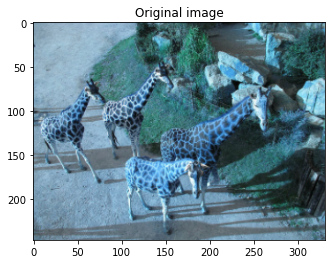

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms
from PIL import Image


def load_image(image_path): # predicts from any image
    image = Image.open(image_path).convert('RGB')
    # Image preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    image = image.resize([224, 224], Image.LANCZOS)
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    image = transform(image).unsqueeze(0)

    # Load vocabulary wrapper
    with open('vocab.pkl', 'rb') as f: # vocab path
        vocab = pickle.load(f)


    encoder = EncoderCNN(300).eval()  # eval mode (batchnorm uses moving mean/variance)
    decoder = DecoderRNN(300, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    
    encoder.load_state_dict(torch.load('models/encoder-1.pkl')) # encoder path
    decoder.load_state_dict(torch.load('models/decoder-1.pkl')) # decoder path

    
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
#     print(decoder.sample(feature))
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    
    print (sentence)
    return sentence

load_image('example.png')

import cv2 as cv

image = cv.imread('example.png')


plt.imshow(image)
plt.title('Original image')    #, plt.xticks([]), plt.yticks([])
plt.show()